In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
from signal_modules.signal_registry import SignalRegistry

In [3]:
signal_registry = SignalRegistry()

In [4]:
signal_registry.available_signals()

['ma_crossover', 'Kalman']

In [5]:
#model = signal_registry.get('ma_crossover')()
model = signal_registry.get('Kalman')()

In [6]:
initial_time = pd.to_datetime('2020-01-01T12:00:00+00:00')
initial_time

Timestamp('2020-01-01 12:00:00+0000', tz='UTC')

In [7]:
tickers = ['SPY', 'TSLA', 'NVDA', 'BRK-B']  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {ticker: pd.read_parquet(path).loc[initial_time:] for ticker, path in zip(tickers, data_files)}
timeline = pd.DatetimeIndex(
            pd.to_datetime(
                sorted(set().union(*[df.index for df in data.values()]))
            )
        )
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}

In [8]:
sigs = model.generate_signals(data)

In [9]:
sigs

{'SPY': 0.7913131436022146,
 'TSLA': 0.5875125246117394,
 'NVDA': 0.17838086243497525,
 'BRK-B': 0.42389988160664754}

UKF forecasting: 100%|██████████| 1351/1351 [00:10<00:00, 126.47it/s]


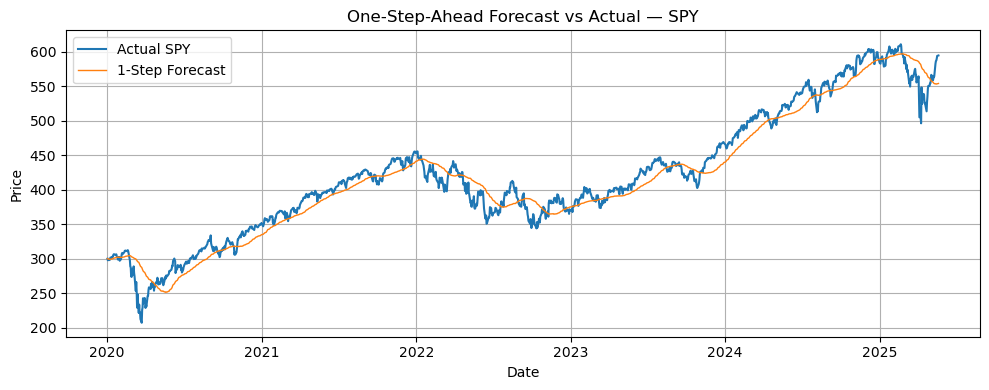

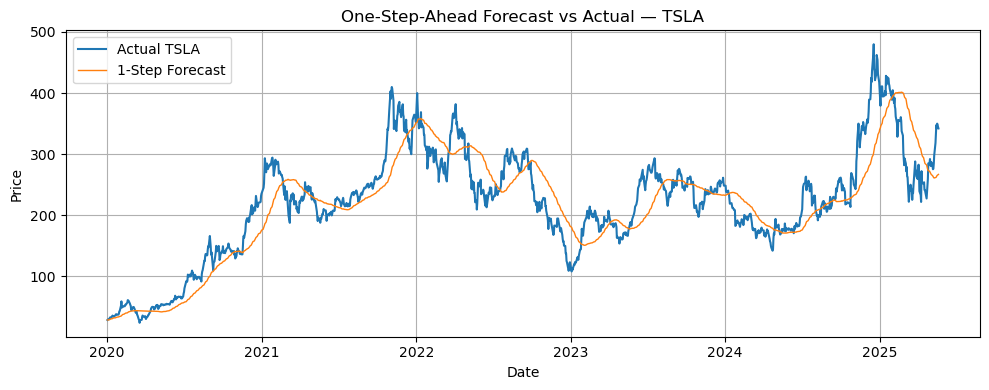

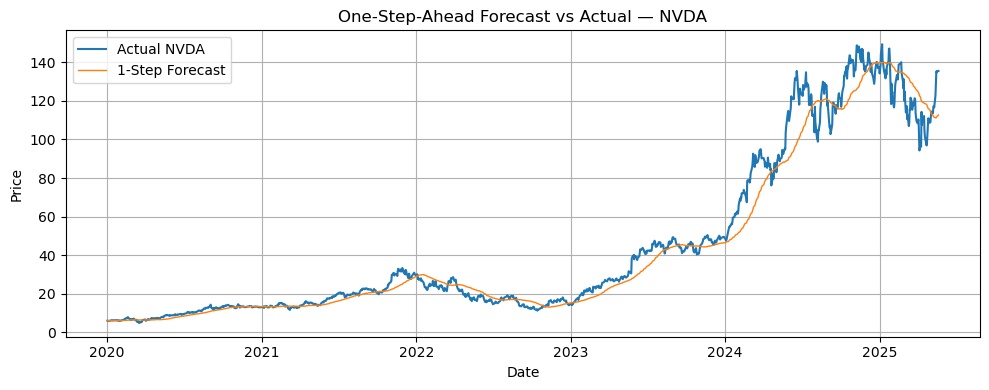

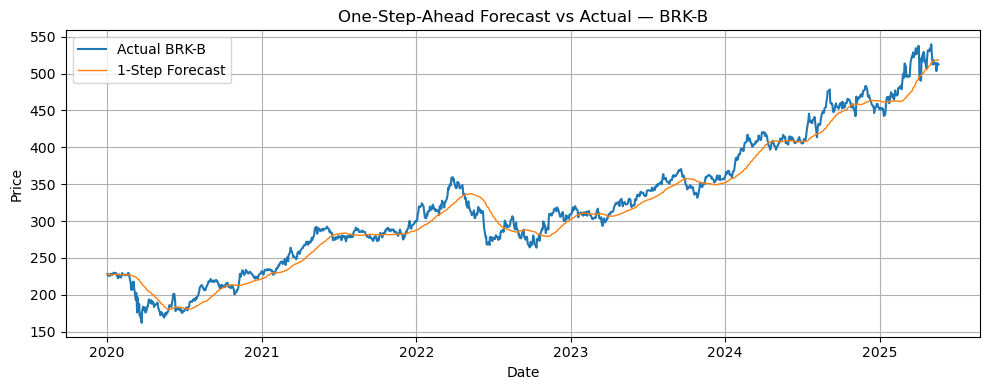

In [10]:
model.plot_cumulative_returns(data)